In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
%matplotlib inline
import seaborn as sns

import sys,os,pdb,copy,pickle
from importlib import reload
import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp
import database
db = database.db

import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)


67 sessions!
67 sessions!


<module 'switch_analysis_one_session' from '/mnt/home/szheng/projects/nmf_analysis/scripts/switch_analysis_one_session.py'>

In [2]:
# data_dir_full = '/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/'
data_dir_full = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)['data_dir_full'][2] #0
print(data_dir_full)
# load data
mat_to_return=prep.load_stuff(data_dir_full,sessionPulses='*SessionPulses.Events.mat')
# sessionPulses=mat_to_return['sessionPulses']
# filtered = mat_to_return['filtered']
behavior=mat_to_return['behavior']
# ripples = mat_to_return['ripples']
cell_metrics = mat_to_return['cell_metrics']

prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=False,extra_load={})
spk_beh_df=prep_res['spk_beh_df']
_,spk_beh_df = dpp.group_into_trialtype(spk_beh_df)
spk_beh_df,_=dpp.add_lin_binned(spk_beh_df,nbins=100)
cell_cols_d = prep_res['cell_cols_d']
beh_df = prep_res['beh_df']
beh_df_d,beh_df=dpp.group_into_trialtype(beh_df)
spike_trains = prep_res['spike_trains']


/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118


/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


load *SessionPulses.Events.mat failed


In [3]:
reload(pa)
cell_cols = cell_cols_d['pyr']
fr_map_d,_,_ = pf.ratemap_from_spk_beh_df_alltrialtype(spk_beh_df,cell_cols_d['pyr'],speed_thresh=1,nbins=100,smth_in_bin=5,speed_key='v')
fr_map_dict=pa.get_fr_map_trial(spk_beh_df,cell_cols,trialtype_key='trial_type',speed_thresh=1.,order=['smooth','divide'],speed_key='v')
fr_map_trial_d = {k:val[0] for k,val in fr_map_dict.items()}
fr_map_trial_df_d=pd.concat({k:pf.fr_map_trial_to_df(fr_map_trial_d[k],cell_cols) for k in fr_map_dict.keys()},axis=0)


cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe


In [4]:
pf_res =pf.field_detection_both_avg_trial_wrapper(data_dir_full, dosave=True,force_reload=False,nbins = 100, 
                                        save_fn = 'place_field_avg_and_trial_vthresh.p', 
                                        shuffle_fn='fr_map_null_trialtype_vthresh.p',
                                        smth_in_bin=2.5, speed_thresh=1.,speed_key='v',load_only=True
                                        )

switch_res = saos.switch_analysis_one_session(data_dir_full,place_field_res=None,force_reload=False,nrepeats=1000,
                                              save_fn=saos.SAVE_FN(saos.FR_KEY),load_only=True)

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---


In [12]:
task_ind,tt_ind = 0,0
pf_param = pf_res['avg']['params'][task_ind,tt_ind]
changes_df = switch_res['avg']['changes_df'].loc[task_ind,tt_ind,0.3,'switch_magnitude',0.4].dropna(axis=1)
fr_map_trial_df = fr_map_trial_df_d.loc[task_ind,tt_ind].dropna(axis=1)

no_sw_fields = changes_df.loc[(changes_df.abs().sum(axis=1) ==0)].index
with_sw_fields = changes_df.loc[(changes_df.abs().sum(axis=1) !=0)].index

/tmp/ipykernel_510778/3810986821.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  changes_df = switch_res['avg']['changes_df'].loc[task_ind,tt_ind,0.3,'switch_magnitude',0.4].dropna(axis=1)


# ratemap before popup trial

In [14]:
import plot_ratemap_sequence as prs

In [62]:
def ratemap_before_popup(changes_df,fr_map_trial,fig=None,axs=None,normalize={'pre':True,'post':True},vmax=None):
    '''
    changes_df: nfields x ntrials
    fr_map_trial: (ncells x nposbins) x ntrials
    '''
    # find pop up trial for each field (neuron) (using all)
    with_sw_fields = changes_df.loc[((changes_df==1).sum(axis=1) !=0)].index
#     with_sw_cells = with_sw_fields.get_level_values(0)
#     with_sw_cells = with_sw_cells[~with_sw_cells.duplicated]
    
    all_fields_inds = changes_df.index
    all_trials_inds = changes_df.columns
    rowinds,colinds = np.nonzero((changes_df ==1).values)
    sw_on_fields = all_fields_inds[rowinds]
    sw_on_trials = all_trials_inds[colinds]
    
    # compute pre and post rate map
    re_computed_fr_map = {'post':{},'pre':{}}
    for (ci,fi),tr in zip(sw_on_fields,sw_on_trials):
        # post
        re_computed_fr_map['post'][ci]=fr_map_trial.loc[ci,tr:].mean(axis=1)
        # pre
        assert tr >= 1, f"{ci},{fi},{tr}"
        re_computed_fr_map['pre'][ci]=fr_map_trial.loc[ci,:tr-1].mean(axis=1)
    
#     re_computed_fr_map = pd.DataFrame(re_computed_fr_map)
    re_computed_fr_map = pd.concat({k:pd.concat(val,axis=1).T for k,val in re_computed_fr_map.items()})
    
    if axs is None:
        fig,axs = plt.subplots(1,2,sharex=True,sharey=True)
#     do rate map
    post_fr_map = re_computed_fr_map.loc['post']
    
    if (not normalize['pre']) and (not normalize['post']): # if not normalize, then use the scale of post
        vmax = post_fr_map.max().max() * 0.95
    
    fig,ax,order = prs.plot_population_sequence(post_fr_map,order=None,fr_map_for_order=None,fig=fig,ax=axs[1],normalize=normalize['post'],vmax=vmax)
    ax.set_title('post ON')
    
    pre_fr_map = re_computed_fr_map.loc['pre']
    
        
    fig,ax,_ = prs.plot_population_sequence(pre_fr_map,order=order,fr_map_for_order=None,fig=fig,ax=axs[0],normalize=normalize['pre'],vmax=vmax)
    ax.set_title('pre ON')
    
    return fig,ax,re_computed_fr_map
    
    


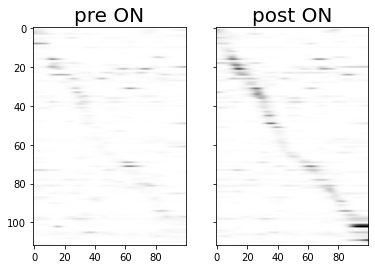

In [63]:
%matplotlib inline
fig,ax,re_computed_fr_map = ratemap_before_popup(changes_df,fr_map_trial_df,normalize={'pre':False,'post':False})

In [65]:
fr_map_null = pf.get_fr_map_shuffle_wrapper(data_dir_full,nrepeats=1000, dosave=True,force_reload=False,nbins = 100, save_fn='fr_map_null_trialtype_vthresh.p',speed_key='v')



/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118/py_data/fr_map_null_trialtype_vthresh.p exists; loading---


In [67]:
fr_map_null[task_ind,tt_ind]

lin_binned        2         3         4         5         6         7   \
0   1.0     0.137807  0.127067  0.111091  0.095654  0.084168  0.077997   
    39.0    3.176255  3.056758  2.890936  2.752838  2.682150  2.693294   
    40.0    1.858759  1.885980  1.919508  1.942423  1.955839  1.978260   
    42.0    9.349493  9.076966  8.646436  8.167955  7.693171  7.242481   
    46.0    4.776683  4.678703  4.512472  4.303682  4.061627  3.792345   
...              ...       ...       ...       ...       ...       ...   
999 359.0   1.058824  1.160294  1.284302  1.350580  1.317883  1.178410   
    360.0   0.000000  0.000000  0.000000  0.000000  0.000011  0.000097   
    361.0   0.025774  0.028121  0.030929  0.032293  0.031260  0.027717   
    362.0   0.051801  0.056901  0.063632  0.068871  0.071874  0.073907   
    363.0   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

lin_binned        8         9         10        11  ...        83        84  \
0   1.0     0.076606  0.076773  0.072907  0.060930  ...  0.414544  0.470596   
    39.0    2.785500  2.936969  3.091122  3.167469  ...  2.154574  2.086648   
    40.0    2.038958  2.161877  2.337178  2.509445  ...  1.372244  1.400278   
    42.0    6.843976  6.551172  6.416819  6.427802  ...  6.225573  6.256974   
    46.0    3.515525  3.271906  3.108369  3.041150  ...  3.087266  3.172596   
...              ...       ...       ...       ...  ...       ...       ...   
999 359.0   0.949213  0.672606  0.414042  0.235705  ...  1.445002  1.177706   
    360.0   0.000676  0.003235  0.013179  0.044700  ...  0.145297  0.124590   
    361.0   0.022181  0.015978  0.011613  0.012919  ...  0.413806  0.383717   
    362.0   0.076945  0.081502  0.084310  0.079430  ...  0.000018  0.000000   
    363.0   0.000000  0.000000  0.000000  0.000000  ...  0.000521  0.000157   

lin_binned        85        86        87        88        89        90  \
0   1.0     0.525835  0.582748  0.641751  0.702404  0.766165  0.834433   
    39.0    2.052512  2.079072  2.187308  2.370374  2.576064  2.732981   
    40.0    1.424021  1.452851  1.492834  1.537364  1.565131  1.557131   
    42.0    6.265481  6.246439  6.180157  6.036914  5.802023  5.506194   
    46.0    3.293570  3.448718  3.627381  3.801456  3.934636  4.009107   
...              ...       ...       ...       ...       ...       ...   
999 359.0   0.946834  0.765342  0.625805  0.509831  0.400184  0.293792   
    360.0   0.113384  0.111049  0.123079  0.161350  0.237101  0.346702   
    361.0   0.345290  0.295472  0.232478  0.161779  0.096416  0.048413   
    362.0   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    363.0   0.000043  0.000010  0.000000  0.000000  0.000000  0.000000   

lin_binned        91        92  
0   1.0     0.899817  0.942355  
    39.0    2.808256  2.826342  
    40.0    1.519714  1.485294  
    42.0    5.226037  5.053770  
    46.0    4.036875  4.042750  
...              ...       ...  
999 359.0   0.203971  0.151596  
    360.0   0.462342  0.538708  
    361.0   0.020721  0.009013  
    362.0   0.000000  0.000000  
    363.0   0.000000  0.000000  

[318000 rows x 91 columns]

In [78]:
reload(pf)

<module 'place_field_analysis' from '/mnt/home/szheng/projects/util_code/place_field_analysis.py'>

In [82]:
null

lin_binned        2         3         4         5         6         7   \
46  1.0     0.277919  0.242731  0.189987  0.137459  0.094805  0.067096   
    39.0    2.418631  2.462195  2.513562  2.541398  2.539090  2.520147   
    40.0    1.380551  1.358127  1.316110  1.255580  1.176455  1.084417   
    42.0    4.448751  4.483299  4.538402  4.591253  4.610684  4.553547   
    46.0    2.902805  2.928622  2.946321  2.917400  2.815755  2.629345   
...              ...       ...       ...       ...       ...       ...   
361 359.0   0.062488  0.070813  0.086106  0.107455  0.134761  0.167824   
    360.0   0.001740  0.003765  0.008570  0.017608  0.032754  0.055267   
    361.0   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    362.0   0.107526  0.106539  0.102648  0.094308  0.081458  0.065193   
    363.0   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

lin_binned        8         9         10        11  ...        83        84  \
46  1.0     0.060313  0.084225  0.148212  0.247500  ...  0.063375  0.060544   
    39.0    2.508469  2.527465  2.585726  2.671690  ...  2.438963  2.520840   
    40.0    1.000429  0.963984  1.012257  1.133676  ...  1.753641  1.877437   
    42.0    4.366615  4.009053  3.503719  2.978806  ...  5.146827  5.179217   
    46.0    2.362096  2.039349  1.708274  1.424707  ...  3.788277  3.840360   
...              ...       ...       ...       ...  ...       ...       ...   
361 359.0   0.205770  0.248161  0.295901  0.346754  ...  0.884786  0.828023   
    360.0   0.083564  0.110282  0.122896  0.113012  ...  0.130710  0.111629   
    361.0   0.000000  0.000000  0.000000  0.000000  ...  0.118368  0.140795   
    362.0   0.047345  0.030270  0.016429  0.007351  ...  0.000000  0.000000   
    363.0   0.000000  0.000000  0.000022  0.000118  ...  0.000058  0.000198   

lin_binned        85        86        87        88        89        90  \
46  1.0     0.055513  0.047205  0.035962  0.023721  0.013172  0.006073   
    39.0    2.619648  2.733544  2.849295  2.940811  2.983279  2.975841   
    40.0    1.995248  2.099888  2.179390  2.219630  2.215799  2.181557   
    42.0    5.208147  5.239788  5.263345  5.260791  5.229314  5.191080   
    46.0    3.784291  3.607237  3.300114  2.891981  2.471653  2.145071   
...              ...       ...       ...       ...       ...       ...   
361 359.0   0.861342  1.004999  1.244055  1.509471  1.698356  1.748012   
    360.0   0.127696  0.197873  0.341156  0.559891  0.820366  1.062064   
    361.0   0.155089  0.159119  0.152431  0.138178  0.123454  0.115063   
    362.0   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    363.0   0.000721  0.002376  0.006932  0.017446  0.037008  0.065410   

lin_binned        91        92  
46  1.0     0.002349  0.000911  
    39.0    2.943935  2.918627  
    40.0    2.141206  2.115558  
    42.0    5.169516  5.165331  
    46.0    1.959381  1.888214  
...              ...       ...  
361 359.0   1.689523  1.619388  
    360.0   1.235097  1.321258  
    361.0   0.114125  0.116098  
    362.0   0.000000  0.000000  
    363.0   0.096008  0.116596  

[35616 rows x 91 columns]

In [83]:
null

lin_binned        2         3         4         5         6         7   \
46  1.0     0.277919  0.242731  0.189987  0.137459  0.094805  0.067096   
    39.0    2.418631  2.462195  2.513562  2.541398  2.539090  2.520147   
    40.0    1.380551  1.358127  1.316110  1.255580  1.176455  1.084417   
    42.0    4.448751  4.483299  4.538402  4.591253  4.610684  4.553547   
    46.0    2.902805  2.928622  2.946321  2.917400  2.815755  2.629345   
...              ...       ...       ...       ...       ...       ...   
361 359.0   0.062488  0.070813  0.086106  0.107455  0.134761  0.167824   
    360.0   0.001740  0.003765  0.008570  0.017608  0.032754  0.055267   
    361.0   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    362.0   0.107526  0.106539  0.102648  0.094308  0.081458  0.065193   
    363.0   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

lin_binned        8         9         10        11  ...        83        84  \
46  1.0     0.060313  0.084225  0.148212  0.247500  ...  0.063375  0.060544   
    39.0    2.508469  2.527465  2.585726  2.671690  ...  2.438963  2.520840   
    40.0    1.000429  0.963984  1.012257  1.133676  ...  1.753641  1.877437   
    42.0    4.366615  4.009053  3.503719  2.978806  ...  5.146827  5.179217   
    46.0    2.362096  2.039349  1.708274  1.424707  ...  3.788277  3.840360   
...              ...       ...       ...       ...  ...       ...       ...   
361 359.0   0.205770  0.248161  0.295901  0.346754  ...  0.884786  0.828023   
    360.0   0.083564  0.110282  0.122896  0.113012  ...  0.130710  0.111629   
    361.0   0.000000  0.000000  0.000000  0.000000  ...  0.118368  0.140795   
    362.0   0.047345  0.030270  0.016429  0.007351  ...  0.000000  0.000000   
    363.0   0.000000  0.000000  0.000022  0.000118  ...  0.000058  0.000198   

lin_binned        85        86        87        88        89        90  \
46  1.0     0.055513  0.047205  0.035962  0.023721  0.013172  0.006073   
    39.0    2.619648  2.733544  2.849295  2.940811  2.983279  2.975841   
    40.0    1.995248  2.099888  2.179390  2.219630  2.215799  2.181557   
    42.0    5.208147  5.239788  5.263345  5.260791  5.229314  5.191080   
    46.0    3.784291  3.607237  3.300114  2.891981  2.471653  2.145071   
...              ...       ...       ...       ...       ...       ...   
361 359.0   0.861342  1.004999  1.244055  1.509471  1.698356  1.748012   
    360.0   0.127696  0.197873  0.341156  0.559891  0.820366  1.062064   
    361.0   0.155089  0.159119  0.152431  0.138178  0.123454  0.115063   
    362.0   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    363.0   0.000721  0.002376  0.006932  0.017446  0.037008  0.065410   

lin_binned        91        92  
46  1.0     0.002349  0.000911  
    39.0    2.943935  2.918627  
    40.0    2.141206  2.115558  
    42.0    5.169516  5.165331  
    46.0    1.959381  1.888214  
...              ...       ...  
361 359.0   1.689523  1.619388  
    360.0   1.235097  1.321258  
    361.0   0.114125  0.116098  
    362.0   0.000000  0.000000  
    363.0   0.096008  0.116596  

[35616 rows x 91 columns]

In [88]:
null

lin_binned        2         3         4         5         6         7   \
0   46.0    4.776683  4.678703  4.512472  4.303682  4.061627  3.792345   
    52.0    1.251464  1.311668  1.409048  1.519871  1.630178  1.731755   
    54.0    2.335051  2.246382  2.121344  2.014850  1.960251  1.977637   
    56.0    4.646680  4.479842  4.208973  3.898682  3.586976  3.297014   
    60.0    0.399641  0.401480  0.403855  0.405895  0.407809  0.410033   
...              ...       ...       ...       ...       ...       ...   
999 354.0   0.334779  0.323398  0.303754  0.279555  0.254385  0.232987   
    358.0   0.650902  0.664404  0.690708  0.732779  0.798376  0.896304   
    359.0   1.058824  1.160294  1.284302  1.350580  1.317883  1.178410   
    360.0   0.000000  0.000000  0.000000  0.000000  0.000011  0.000097   
    361.0   0.025774  0.028121  0.030929  0.032293  0.031260  0.027717   

lin_binned        8         9         10        11  ...        83        84  \
0   46.0    3.515525  3.271906  3.108369  3.041150  ...  3.087266  3.172596   
    52.0    1.816957  1.878278  1.914665  1.941303  ...  2.056166  1.996854   
    54.0    2.085175  2.297421  2.598858  2.905896  ...  1.005233  1.112599   
    56.0    3.051866  2.879293  2.805699  2.840381  ...  2.120085  2.262390   
    60.0    0.411588  0.408615  0.395157  0.368561  ...  0.541502  0.552230   
...              ...       ...       ...       ...  ...       ...       ...   
999 354.0   0.222539  0.232686  0.273588  0.351497  ...  0.332222  0.376402   
    358.0   1.028728  1.180772  1.317414  1.403808  ...  0.495810  0.521564   
    359.0   0.949213  0.672606  0.414042  0.235705  ...  1.445002  1.177706   
    360.0   0.000676  0.003235  0.013179  0.044700  ...  0.145297  0.124590   
    361.0   0.022181  0.015978  0.011613  0.012919  ...  0.413806  0.383717   

lin_binned        85        86        87        88        89        90  \
0   46.0    3.293570  3.448718  3.627381  3.801456  3.934636  4.009107   
    52.0    1.897015  1.773611  1.642141  1.518392  1.416285  1.342479   
    54.0    1.229351  1.337452  1.433105  1.535268  1.676367  1.867101   
    56.0    2.365958  2.437726  2.469942  2.447852  2.370771  2.264992   
    60.0    0.563078  0.579086  0.597071  0.606653  0.597577  0.570052   
...              ...       ...       ...       ...       ...       ...   
999 354.0   0.403721  0.407492  0.382061  0.328687  0.259993  0.194452   
    358.0   0.611669  0.790955  1.075033  1.451036  1.866658  2.250733   
    359.0   0.946834  0.765342  0.625805  0.509831  0.400184  0.293792   
    360.0   0.113384  0.111049  0.123079  0.161350  0.237101  0.346702   
    361.0   0.345290  0.295472  0.232478  0.161779  0.096416  0.048413   

lin_binned        91        92  
0   46.0    4.036875  4.042750  
    52.0    1.295826  1.273202  
    54.0    2.067257  2.199442  
    56.0    2.169715  2.115291  
    60.0    0.536688  0.514291  
...              ...       ...  
999 354.0   0.145804  0.120381  
    358.0   2.543724  2.703395  
    359.0   0.203971  0.151596  
    360.0   0.462342  0.538708  
    361.0   0.020721  0.009013  

[112000 rows x 91 columns]

In [87]:
null = fr_map_null[task_ind,tt_ind].loc[(slice(None),re_computed_fr_map.loc['pre'].index),:]
todetect = re_computed_fr_map.loc['pre'].stack().to_frame()
# todetect = {tt_ind:todetect}
all_fields_bounds_avg, sig_thresh_map=pf.detect_significant_segments(null,todetect)




In [93]:
((changes_df==1).sum(axis=1)>0).sum()

125

In [112]:
%matplotlib auto
def test_plot():
#     plt.ioff()
    plt.plot(np.ones(10))

Using matplotlib backend: agg


In [114]:
nplots_per_page = 2
data_all = [np.zeros(10) for i in range(20)]
def plot_one_func(data_one,fig=None,ax=None):
    ax.plot(data_one)
    return fig,ax


In [151]:
reload(ph)

<module 'plot_helper' from '/mnt/home/szheng/projects/util_code/plot_helper.py'>

In [124]:
import misc
reload(misc)

<module 'misc' from '/mnt/home/szheng/projects/util_code/misc.py'>

In [133]:
from matplotlib.backends.backend_pdf import PdfPages

In [150]:
np.ceil(20 /15)

2.0

In [153]:
reload(ph)
ph.plot_multipage_wrapper(plot_one_func,data_all,title_all=None,func_args=(),func_kwargs={}, nplots_per_page=15,fig_save_fn='fig_temp',fig_save_dir='./')




> /mnt/home/szheng/projects/util_code/plot_helper.py(119)plot_multipage_wrapper()
    117                 plot_ind += 1
    118             pdb.set_trace()
--> 119             pdf.savefig(figure=fig,bbox_inches='tight')
    120             plt.close(fig=fig)
    121 

ipdb> c
> /mnt/home/szheng/projects/util_code/plot_helper.py(118)plot_multipage_wrapper()
    116                 ax.set_title(title)
    117                 plot_ind += 1
--> 118             pdb.set_trace()
    119             pdf.savefig(figure=fig,bbox_inches='tight')
    120             plt.close(fig=fig)

ipdb> c
./fig_temp.pdf saved!


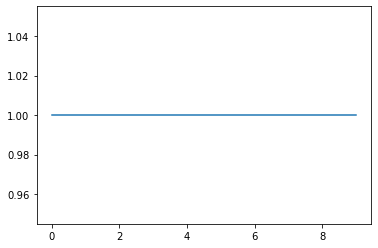

In [110]:
test_plot()

<AxesSubplot:>

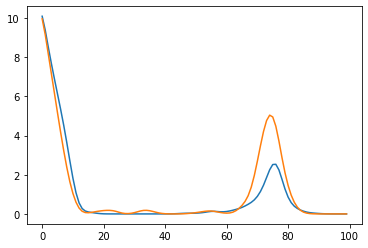

In [108]:
uid = 353
re_computed_fr_map.loc['pre'].loc[uid].plot()

re_computed_fr_map.loc['post'].loc[uid].plot()

In [106]:
pf_res['avg']['all_fields'][0,0].loc[46]

,start,end,com,peak,fr_peak,fr_mean
field_index,,,,,,
0,10,21,15,15,11.998762,9.144179
1,43,73,57,47,6.677023,5.225121


In [89]:
all_fields_bounds_avg

start end  field_index  trial  peak  com    fr_peak   fr_mean
46  0    45  54            0      0    48   49   7.667922  6.104239
    0    66  74            2      0    70   70   9.127688  7.423502
52  0     2   8            0      0     5    4   4.388873  4.177974
    0    23  38            1      0    30   30   7.570883  6.031772
    0    80  92            2      0    90   86   4.700283  3.955219
...     ...  ..          ...    ...   ...  ...        ...       ...
353 0    72  79            1      0    76   75   2.532932  1.989377
354 0    50  61            0      0    56   55   3.716270  2.394626
358 0     2   8            0      0     2    4   6.117773  4.398060
    0    73  82            1      0    77   77   3.508142  2.589095
359 0    13  19            0      0    16   15  12.827581  9.385804

[132 rows x 8 columns]

In [64]:
re_computed_fr_map.loc['pre']

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
46,1.465977,1.455802,1.418305,1.346393,1.245162,1.122029,0.983175,0.832557,0.672140,0.504895,...,0.823051,0.781830,0.767229,0.753420,0.728096,0.688276,0.639962,0.583795,0.521573,0.458583
52,4.151320,4.173423,4.236466,4.317440,4.381540,4.388873,4.292558,4.041231,3.587710,2.914868,...,4.700283,4.660531,4.514509,4.283359,3.992202,3.662867,3.312565,2.953933,2.576093,2.193996
54,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.150970,0.811028,0.621590,0.516855,0.448162,0.391970,0.339573,0.289509,0.240002,0.193205
56,1.570270,1.667598,1.764082,1.841014,1.907695,1.968133,2.016363,2.036646,2.004185,1.895181,...,0.004530,0.001355,0.000330,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
60,1.739032,1.621615,1.480807,1.333992,1.179156,1.016495,0.849093,0.680083,0.512260,0.353146,...,0.120561,0.130562,0.143071,0.151321,0.152592,0.147034,0.136606,0.122591,0.105847,0.088859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,0.446246,0.401099,0.349434,0.303396,0.262779,0.226251,0.192078,0.157980,0.123460,0.093102,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
358,6.542713,6.378193,6.117773,5.763899,5.286282,4.659315,3.880077,2.989715,2.089362,1.318481,...,1.952789,2.489459,3.009289,3.503164,3.970778,4.414821,4.833725,5.231132,5.631952,6.056963
359,0.132643,0.177432,0.230921,0.280805,0.325135,0.362213,0.390156,0.408000,0.421255,0.462816,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
360,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.094160,0.042808,0.017584,0.006699,0.002442,0.000000,0.000000,0.000000,0.000000,0.000000
